# Gradient Boosting Model

HistGradientBoostingClassifier baseline with cross-validation and holdout evaluation on the Grand Prix dataset.


In [15]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.metrics import balanced_accuracy_score


In [16]:
DATA_PATH = Path('data/grandprix_features_5.csv')
CAT_COLS = [
    'driver_id',
    'constructor_id',
    'circuit_id',
]
NUM_COLS = [
    'grid_position',
    'quali_delta',
    'quali_tm_delta',
    'season_pts_driver',
    'season_pts_team',
    'last_3_avg',
    'is_street_circuit',
    'is_wet',
]
TARGET = 'points_scored'
RANDOM_STATE = 42

df = pd.read_csv(DATA_PATH)

df.head()


,driver_id,constructor_id,circuit_id,grid_position,quali_delta,quali_tm_delta,season_pts_driver,season_pts_team,last_3_avg,is_street_circuit,is_wet,points_scored
0,leclerc,ferrari,sakhir,1,0.000,-0.129,0.0,0.0,0.0,0,0,1
1,sainz,ferrari,sakhir,3,0.129,0.129,0.0,26.0,0.0,0,0,1
2,hamilton,mercedes,sakhir,5,0.490,-0.204,0.0,0.0,0.0,0,0,1
3,russell,mercedes,sakhir,9,0.694,0.204,0.0,15.0,0.0,0,0,1
4,magnussen,haas_f1_team,sakhir,7,0.903,-0.537,0.0,0.0,0.0,0,0,1


In [17]:
# Load data
print(f'Rows: {len(df)}')
print(df.head())

X = df[CAT_COLS + NUM_COLS]
y = df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print('Train/Test shapes:', X_train.shape, X_test.shape)


Rows: 1838
   driver_id constructor_id circuit_id  grid_position  quali_delta  \
0    leclerc        ferrari     sakhir              1        0.000   
1      sainz        ferrari     sakhir              3        0.129   
2   hamilton       mercedes     sakhir              5        0.490   
3    russell       mercedes     sakhir              9        0.694   
4  magnussen   haas_f1_team     sakhir              7        0.903   

   quali_tm_delta  season_pts_driver  season_pts_team  last_3_avg  \
0          -0.129                0.0              0.0         0.0   
1           0.129                0.0             26.0         0.0   
2          -0.204                0.0              0.0         0.0   
3           0.204                0.0             15.0         0.0   
4          -0.537                0.0              0.0         0.0   

   is_street_circuit  is_wet  points_scored  
0                  0       0              1  
1                  0       0              1  
2              

In [18]:
# HistGradientBoosting pipeline
hgb = make_pipeline(
    SimpleImputer(strategy='median'),
    HistGradientBoostingClassifier(
        loss='log_loss',
        learning_rate=0.05,
        max_depth=5,
        max_iter=400,
        random_state=RANDOM_STATE,
    ),
)

# Fit on training data
hgb.fit(X_train, y_train)

y_pred = hgb.predict(X_test)
y_proba = hgb.predict_proba(X_test)[:, 1]


print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 (binary):', f1_score(y_test, y_pred))
print('F1 (macro):', f1_score(y_test, y_pred, average="macro"))
print('Balanced accuracy:', balanced_accuracy_score(y_test, y_pred))


ValueError: Cannot use median strategy with non-numeric data:
could not convert string to float: 'hulkenberg'

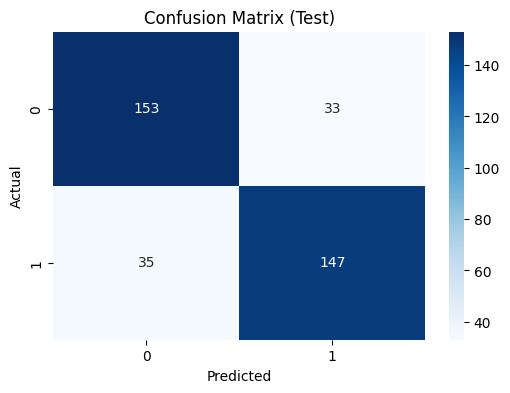

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()